## Europe Street Signs Classification

This is another beginning level notebook.  The images can be greyscale because street signs must be recognized by someone that is color blind.  There are many different ways to load the data, I used the source, but if you do a Google search on “GTSRB Data” you will see other options.

The GTSRB database images are in .ppg format – TensorFlow does not natively handle that format, so we need to read them into an array using another library, like CV2 or PIL.

The first time I attempted training GTSRB, I did have a major learning experience around understanding the problem and applying augmentations.  

Normally, you can rotate or flip training images, so my first time I used these but obtained very bad results.  Why?  If you rotate many of the street signs, it changes the label.  For example, a "right turn" sign flipped starts to look like a "left turn" sign, etc.   My lesson was that you always need to look at the augmented images to make sure nothing unexpected was introduced.  You can add things like zoom, blur and crop.  Just make sure to keep the original orientation of the image.

The results after 5 EPOCS are in the 90%'s, if you run it longer it will start to overfit and you will need to add some augmentations to the training set.  If you want to add augmentations, it would be easier to use a Keras generator to load and then apply augmentations.

In real-world usage, you would want a much higher accuracy - self-driving cars need to understand street signs!

I just loaded the np arrays for training, if you want to use datasets, look at the bottom where I create a dataset for validation, "val_dataset".

Accuracy : 0.9387755102040817

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.92857   0.96296        42
           1    0.99747   0.88964   0.94048       444
           2    0.99528   0.93778   0.96568       450
           3    0.98268   0.80496   0.88499       282
           4    0.93932   0.97727   0.95792       396
           5    0.73523   0.97043   0.83662       372
           6    1.00000   0.88095   0.93671        84
           7    0.71684   0.97569   0.82647       288
           8    0.99441   0.63121   0.77223       282
           9    0.82353   1.00000   0.90323       294
          10    0.95012   0.99751   0.97324       401
          11    0.98851   0.97727   0.98286       264
          12    0.96028   0.97857   0.96934       420
          13    0.97738   1.00000   0.98856       432
          14    1.00000   1.00000   1.00000       156
          15    1.00000   0.97619   0.98795       126
          16    0.96386   0.95238   0.95808        84
          17    0.98661   0.99550   0.99103       222
          18    0.95582   0.99167   0.97342       240
          19    0.97222   0.83333   0.89744        42
          20    1.00000   0.77778   0.87500        72
          21    0.86842   1.00000   0.92958        66
          22    1.00000   0.98718   0.99355        78
          23    0.83607   1.00000   0.91071       102
          24    1.00000   0.77778   0.87500        54
          25    1.00000   0.93667   0.96730       300
          26    0.98198   0.90833   0.94372       120
          27    1.00000   0.93750   0.96774        48
          28    1.00000   0.87037   0.93069       108
          29    1.00000   0.57407   0.72941        54
          30    0.75221   0.94444   0.83744        90
          31    0.97403   0.96154   0.96774       156
          32    1.00000   0.89583   0.94505        48
          33    1.00000   0.93478   0.96629       138
          34    0.98824   1.00000   0.99408        84
          35    1.00000   0.97490   0.98729       239
          36    0.98701   0.97436   0.98065        78
          37    0.97436   0.90476   0.93827        42
          38    0.99496   0.95411   0.97411       414
          39    1.00000   0.98333   0.99160        60
          40    0.98333   0.81944   0.89394        72
          41    0.96000   1.00000   0.97959        48
          42    0.95833   0.95833   0.95833        48


In [ ]:
#"""
# Google Collab specific stuff....
from google.colab import drive
drive.mount('/content/drive')

import os
!ls "/content/drive/My Drive"

USING_COLLAB = True
%tensorflow_version 2.x
#"""

In [ ]:
# Setup sys.path to find MachineLearning lib directory

try: USING_COLLAB
except NameError: USING_COLLAB = False

%load_ext autoreload
%autoreload 2

import sys
if "MachineLearning" in sys.path[0]:
    pass
else:
    print(sys.path)
    if USING_COLLAB:
        sys.path.insert(0, '/content/drive/My Drive/GitHub/MachineLearning/lib')  ###### CHANGE FOR SPECIFIC ENVIRONMENT
    else:
        sys.path.insert(0, '/Users/john/Documents/GitHub/MachineLearning/lib')  ###### CHANGE FOR SPECIFIC ENVIRONMENT
    
    print(sys.path)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys, random, warnings, time, copy, csv, gc
import numpy as np 

import IPython.display as display
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange, tqdm
import pandas as pd
from sklearn.utils import shuffle
import glob 

from sklearn.model_selection import train_test_split
from skimage.color import rgb2grey

import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds

AUTOTUNE = tf.data.experimental.AUTOTUNE
print("AUTOTUNE: ", AUTOTUNE)

from TrainingUtils import *

#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

2.2.0
AUTOTUNE:  -1


## Examine and understand data


In [ ]:
# GLOBALS/CONFIG ITEMS

# Set root directory path to data
if USING_COLLAB:
    ROOT_PATH = "/content/drive/My Drive/ImageData/StreetSigns"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
else:
    ROOT_PATH = "/Users/john/Documents/ImageData/StreetSigns"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
        
# Establish global dictionary
parms = GlobalParms(MODEL_NAME="model-StreetSigns-V02.h5",
                    ROOT_PATH=ROOT_PATH,
                    TRAIN_PATH="/GTSRB/Final_Training/Images", 
                    SMALL_RUN=False,
                    NUM_CLASSES=43,
                    CLASS_NAMES=[str(n) for n in list(range(43))],
                    IMAGE_ROWS=32,
                    IMAGE_COLS=32,
                    IMAGE_CHANNELS=1,
                    EPOCS=5, 
                    BATCH_SIZE=32,
                    IMAGE_EXT=".ppm",
                    FINAL_ACTIVATION='softmax',
                    LOSS='categorical_crossentropy',
                    METRICS=['accuracy'])

parms.print_contents()

In [0]:
# Simple helper method to display batches of images with labels....        
def show_batch(image_batch, label_batch, number_to_show=25, r=5, c=5, print_shape=False):
    show_number = min(number_to_show, parms.BATCH_SIZE)

    if show_number < 8: #if small number, then change row, col and figure size
        if parms.IMAGE_COLS > 64 or parms.IMAGE_ROWS > 64:
            plt.figure(figsize=(25,25)) 
        else:
            plt.figure(figsize=(10,10))  
        r = 4
        c = 2 
    else:
        plt.figure(figsize=(10,10))  

    if show_number == 1:
        image_batch = np.expand_dims(image_batch, axis=0)
        label_batch = np.expand_dims(label_batch, axis=0)

    for n in range(show_number):
        if print_shape:
            print("Image shape: {}  Max: {}  Min: {}".format(image_batch[n].shape, np.max(image_batch[n]), np.min(image_batch[n])))
        ax = plt.subplot(r,c,n+1)
        cmap="gray"
        if len(image_batch[n].shape) == 3:
            if image_batch[n].shape[2] == 3:
                cmap="viridis"
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_batch[n]), cmap=plt.get_cmap(cmap))
        plt.title(parms.CLASS_NAMES[np.argmax(label_batch[n])])
        plt.axis('off')

In [6]:
# Download dataset to local VM
import urllib.request

print('Starting download...')
url = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip'
urllib.request.urlretrieve(url, './GTSRB_Final_Training_Images.zip')
print('Finished download...')



Starting download...
Finished download...


In [7]:
!ls
!unzip -q GTSRB_Final_Training_Images.zip
!ls



drive  GTSRB_Final_Training_Images.zip	sample_data
drive  GTSRB  GTSRB_Final_Training_Images.zip  sample_data


In [0]:
!ls GTSRB/Final_Training/Images/

In [ ]:
# path to the images
images = []
image_labels = []
 
# get the image paths
for i in range(parms.NUM_CLASSES):
    image_label_path = parms.TRAIN_PATH + '/' + format(i, '05d') + '/*'+ parms.IMAGE_EXT
    print("Loading...", image_label_path)
    for image_path in glob.glob(image_label_path):
        image = cv2.imread(image_path)
        image = rgb2grey(image)
        image = (image / 255.0) # rescale
        image = cv2.resize(image, (parms.IMAGE_ROWS, parms.IMAGE_COLS))
        images.append(image)
        
        # create one-hot labels
        labels = np.zeros((parms.NUM_CLASSES, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels)

# Add extra axis and return np array
images = np.stack([img[:, :, np.newaxis] for img in images], axis=0).astype(parms.IMAGE_DTYPE)
image_labels = np.matrix(image_labels).astype(parms.IMAGE_DTYPE)

In [0]:
# divide the data into train and test set
(train_X, val_X, train_y, val_y) = train_test_split(images, image_labels, 
                                                      test_size=0.2, 
                                                      stratify=image_labels,
                                                      random_state=20)
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

## Build  model
- add and validate pretrained model as a baseline

In [0]:
# Create any call backs for training...These are the most common.

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, verbose=1, min_lr=1e-6)
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(parms.MODEL_PATH, monitor='val_loss', verbose=1, mode="auto", save_best_only=True)


In [0]:
# Create model and compile it

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam, Nadam, SGD
########

def predict_image(model_passed, image):   
    image = np.expand_dims(image, axis=0)
    predictions = model_passed.predict(image)
    return predictions 


def build_model(parms):
    # initialize the model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=parms.IMAGE_DIM))
    model.add(BatchNormalization(axis=-1))      
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
            
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(parms.NUM_CLASSES, activation=parms.FINAL_ACTIVATION)) 

    return model

def compile_model(parms, model):
    # Optimizers: https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms
    model.compile(loss=parms.LOSS,
          #optimizer=SGD(lr=0.001, momentum=0.9),
          optimizer=Adam(lr=0.001),
          #optimizer="rmsprop",
          metrics=parms.METRICS)
    return model


## Train model

In [0]:
# Train model

model = build_model(parms)
model = compile_model(parms, model)
history = model.fit(train_X, train_y, 
                    validation_data=(val_X, val_y),
                    epochs=parms.EPOCS, 
                    callbacks=[reduce_lr, earlystopper, checkpointer] # include any callbacks...
                    )

In [0]:
# Plot the training history
history_df = pd.DataFrame(history.history)
plt.figure()
history_df[['loss', 'val_loss']].plot(title="Loss")
plt.xlabel('Epocs')
plt.ylabel('Loss')
history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.show()

## Validate model's predictions
- Create actual_lables and predict_labels
- Calculate Confusion Matrix & Accuracy
- Display results


In [35]:
#Load saved model
from tensorflow.keras.models import load_model 
def load_saved_model(model_path):
    model = load_model(model_path)
    print("loaded: ", model_path)
    return model

model = load_saved_model(parms.MODEL_PATH)

loaded:  /content/drive/My Drive/ImageData/StreetSigns/model-StreetSigns-V02.h5


In [0]:
validation_steps = np.ceil(len(val_X) // parms.BATCH_SIZE) # set step sizes based on val & batch
val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_dataset = val_dataset.repeat().batch(parms.BATCH_SIZE)
print("Validation steps: ", validation_steps)

In [40]:
# Use model to generate predicted labels and probabilities
labels, predict_labels, predict_probabilities, bad_results = predictions_using_dataset(model, val_dataset, validation_steps, parms.BATCH_SIZE, create_bad_results_list=False)
#labels, predict_labels, predict_probabilities, bad_results = predictions_using_dataset(model, val_dataset, 1, parms.BATCH_SIZE, create_bad_results_list=False)


245it [04:28,  1.09s/it]

 
total:  7840   Good:  7360.0   Bad:  480.0   percent good:  0.9387755102040817


In [41]:
show_confusion_matrix(labels, predict_labels, parms.CLASS_NAMES, show_graph=False)

Accuracy : 0.9387755102040817

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.92857   0.96296        42
           1    0.99747   0.88964   0.94048       444
           2    0.99528   0.93778   0.96568       450
           3    0.98268   0.80496   0.88499       282
           4    0.93932   0.97727   0.95792       396
           5    0.73523   0.97043   0.83662       372
           6    1.00000   0.88095   0.93671        84
           7    0.71684   0.97569   0.82647       288
           8    0.99441   0.63121   0.77223       282
           9    0.82353   1.00000   0.90323       294
          10    0.95012   0.99751   0.97324       401
          11    0.98851   0.97727   0.98286       264
          12    0.96028   0.97857   0.96934       420
          13    0.97738   1.00000   0.98856       432
          14    1.00000   1.00000   1.00000       156
          15    1.00000   0.97619   0.98795       126
          16    0.96386   0.

total:  7840   Good:  7360.0   Bad:  480.0   percent good:  0.9387755102040817


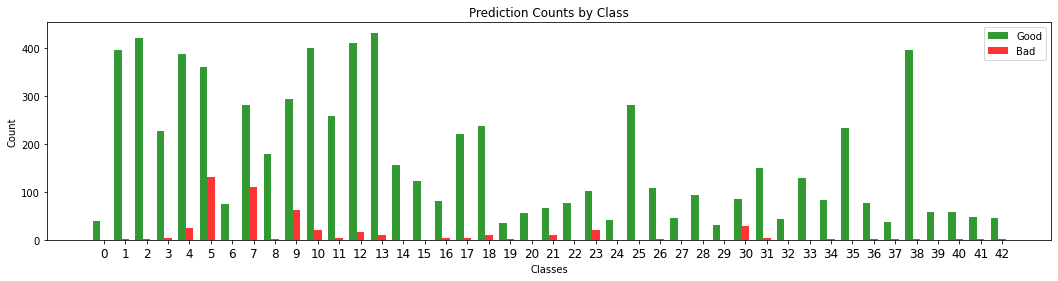

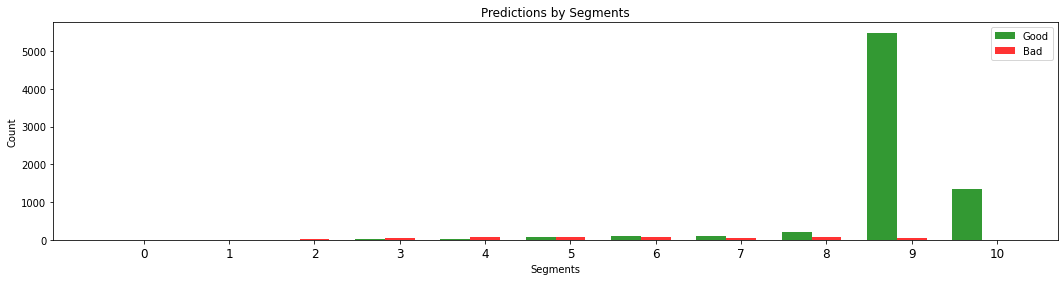

In [48]:
# Graph the results
display_prediction_results(labels, predict_labels, predict_probabilities, parms.NUM_CLASSES, parms.CLASS_NAMES)
